* Youtube video - https://www.youtube.com/watch?v=UvElGVu0cvo&list=PLgMYKvjKE10UZNku-Qx7-z2PEC-7KLiUn&index=1
* paper link - https://arxiv.org/abs/1312.5602
* Github full repo - https://github.com/MaximeVandegar/Papers-in-100-Lines-of-Code/tree/main/Playing_Atari_with_Deep_Reinforcement_Learning

In [1]:
import gymnasium as gym
import ale_py
gym.register_envs(ale_py)
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from stable_baselines3.common.atari_wrappers import MaxAndSkipEnv
from stable_baselines3.common.buffers import ReplayBuffer

In [2]:
class DQN(nn.Module):
    def __init__(self, nb_actions):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(4, 16, 8, stride=4), 
            nn.ReLU(),
            nn.Conv2d(16, 32, 4, stride=4), 
            nn.ReLU(),
            nn.Flatten(), 
            nn.Linear(2592, 256), 
            nn.ReLU(),
            nn.Linear(256, nb_actions)
        )

    def forward(self, x):
        return self.network(x / 255.0)  # Normalize input as Uint8

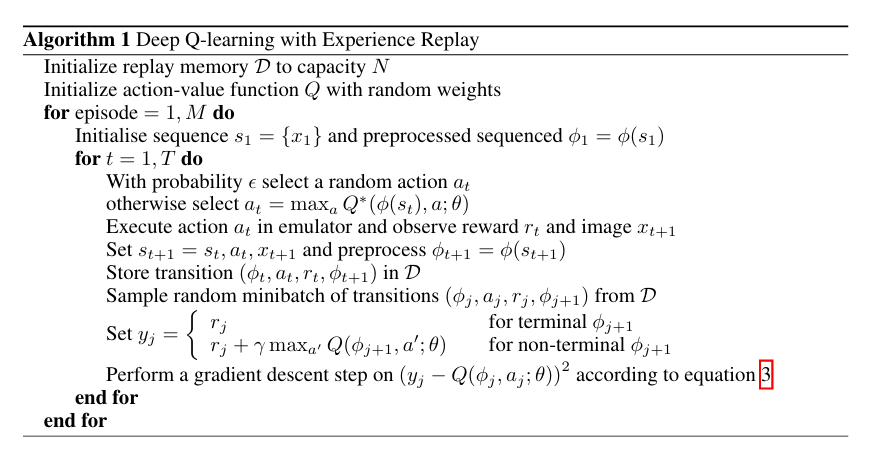

In [6]:
def Deep_Q_Learning(
        env, 
        replay_memory_size=1_000_000,  # This one is important.
        nb_epochs = 30_000_000,  #  48 to 72 hours of training on a modern GPU to converge
        update_frequency = 4,
        batch_size = 32,
        discount_factor = 0.99,
        replay_start_size = 80_000,  # Don't train directly, let agent explore first with a random policy
        initial_exploration = 1.0,  # Random Action
        final_exploration = 0.01,  # Best Action
        exploration_steps = 1_000_000, 
        device = 'cuda'
        ):
    
    # Initialize replay memory D to capacity N
    rb = ReplayBuffer(replay_memory_size,
                      env.observation_space,
                      env.action_space,
                      device=device,
                      optimize_memory_usage = True,
                      handle_timeout_termination = False)
    
    # Initialize action-value function Q with random weights
    q_network = DQN(env.action_space.n).to(device)
    optimizer = torch.optim.Adam(q_network.parameters(), lr=1.25e-4)

    # To plot later
    epoch = 0
    smoothed_rewards = []
    rewards = []

    progress_bar = tqdm(total=nb_epochs)
    while epoch <= nb_epochs:
        dead = False
        total_rewards = 0

        # Initialize sequense s1 = {x1} and preprocessed sequence φ1 = φ(s1)
        obs = env.reset()

        for _ in range(random.randint(1, 30)):  # Noop and fire to reset the environment
            obs, _, _, _, info = env.step(1)

        while not dead:
            current_life = info['lives']

            epsilon = max((final_exploration - initial_exploration) / exploration_steps * epoch + initial_exploration, final_exploration)

            if random.random() < epsilon: # With probability ε select a random action
                action = np.array(env.action_space.sample())
            else: # Otherwise select the best action a = max_a Q(φ(s), a; θ)
                q_values = q_network(torch.tensor(obs).unsqueeze(0).to(device))
                action = torch.argmax(q_values, dim = 1).item()

            # Execute action a in emulator and observe reward r and image x2
            next_obs, reward, dead, _, info = env.step(action)

            done = True if info['lives'] < current_life else False

            # set st+1 = st, at, xt+1 and preprocess φt+1 = φ(st+1)
            real_next_obs = next_obs.copy()

            total_rewards += reward
            reward = np.sign(reward)  # Clip rewards to -1, 0, 1

            # Store transition (φt, at, rt, φt+1) in D
            rb.add(obs, real_next_obs, action, reward, done, info) # Store transition in the replay buffer

            obs = next_obs

            if epoch > replay_start_size and epoch % update_frequency == 0:
                # Sample random minibatch of transitions (φj, aj, rj, φj+1) from D
                data = rb.sample(batch_size)
                with torch.no_grad():
                    max_q_values, _ = q_network(data.next_observations).max(dim=1)
                    y = data.rewards.flatten() + discount_factor * max_q_values * (1 - data.dones.flatten())
                
                current_q_values = q_network(data.observations).gather(1, data.actions).squeeze()
                
                loss = F.huber_loss(y, current_q_values)

                # Perform a gradient descent step according to equation 3
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            epoch += 1
            if (epoch % 50_000 == 0) and epoch > 0:
                smoothed_rewards.append(np.mean(rewards))
                rewards = []
                plt.plot(smoothed_rewards)
                plt.title("Average Reward on Breakout")
                plt.xlabel("Training Epochs")
                plt.ylabel("Average Reward per Episode")
                plt.show()

            progress_bar.update(1)
        rewards.append(total_rewards)    

In [7]:
# !pip install --upgrade ale-py
# !pip install --upgrade "gymnasium[atari, other]"

In [8]:
env = gym.make("ALE/Breakout-v5", 
               render_mode='human'
               )
env = gym.wrappers.RecordEpisodeStatistics(env)
env = gym.wrappers.ResizeObservation(env, (84, 84))
env = gym.wrappers.GrayscaleObservation(env)
env = gym.wrappers.FrameStackObservation(env, 4) # It was frame stack in video
env = MaxAndSkipEnv(env, skip = 4)

Deep_Q_Learning(env, device = 'cuda',
                nb_epochs = 1,
                replay_memory_size = 1000)
env.close()

2it [00:04,  1.74s/it]                       

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0

4it [00:04,  1.47it/s]

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0

6it [00:04,  2.64it/s]

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0

8it [00:04,  1.60it/s]

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0

: 